## LOADING THE DATASET

In [14]:
!pip install kagglehub

In [15]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download from kagglehub
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

# Load the dataset
df = pd.read_csv(f"{path}/creditcard.csv")

In [16]:
# Printing dataset characteristics
print("Shape:", df.shape)
print("Columns:", df.columns)

Shape: (284807, 31)
Columns: Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


Class
0    284315
1       492
Name: count, dtype: int64


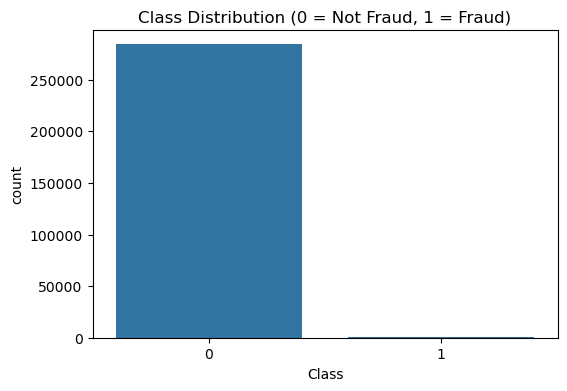

In [17]:
# Visualization of the class imbalance
print(df['Class'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Class')
plt.title('Class Distribution (0 = Not Fraud, 1 = Fraud)')
plt.show()

## PREPROCESSING

In [18]:
# Fraud Ratio
fraud_count = df['Class'].value_counts()
print(fraud_count)

fraud_ratio = fraud_count[1] / fraud_count[0]
print(f"Fraud to Non-Fraud Ratio: {fraud_ratio:.6f}")

Class
0    284315
1       492
Name: count, dtype: int64
Fraud to Non-Fraud Ratio: 0.001730


In [19]:
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df['Class']

# Stratified split to maintain class balance in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
# Standardizing some features for better computation and results
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_test[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

In [21]:
# Since the dataset is heavily imbalanced, apply SMOTE
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

After SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


## EDA

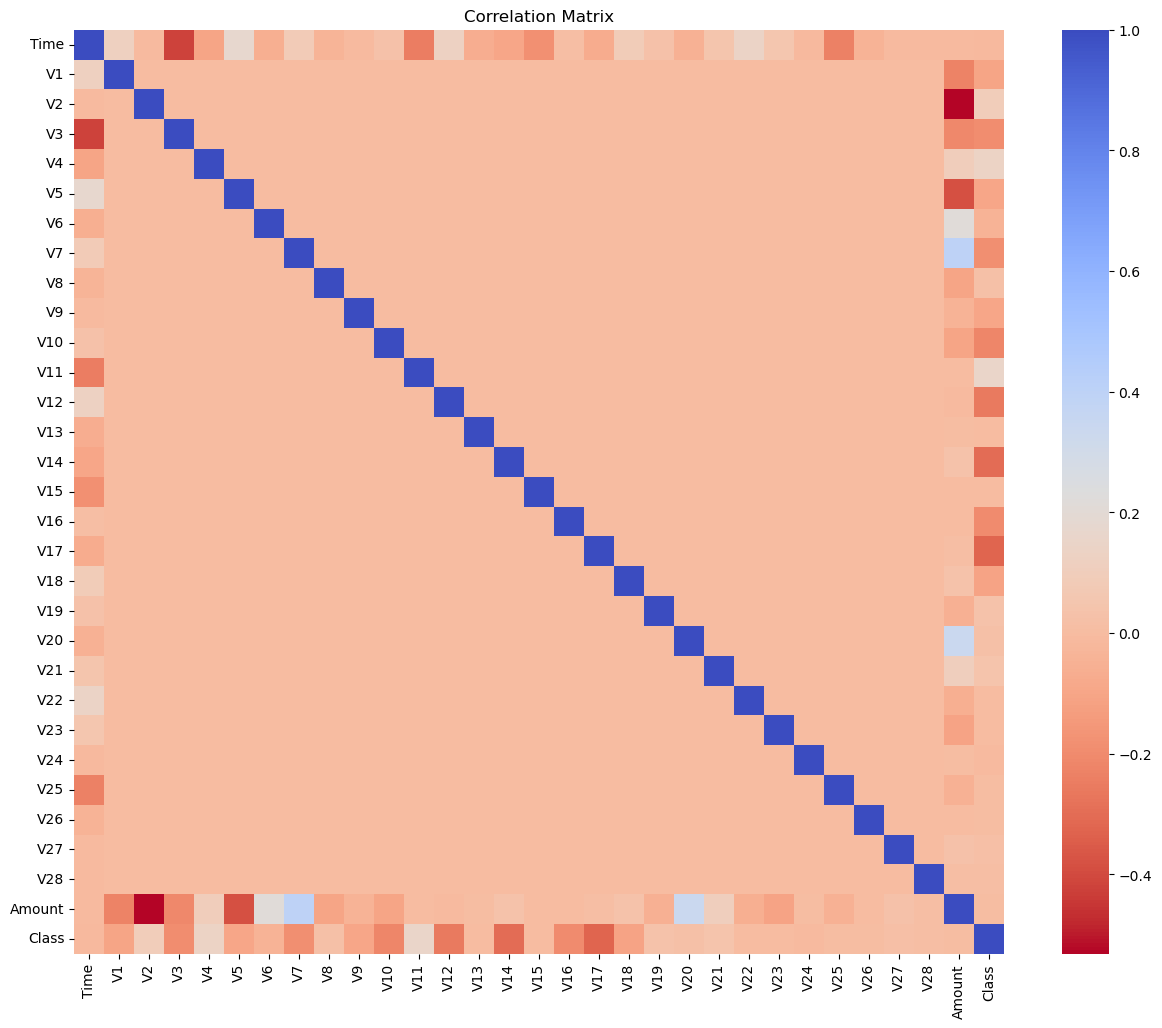

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation and plot the heatmap
corr = df.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap='coolwarm_r', annot=False)
plt.title("Correlation Matrix")
plt.show()

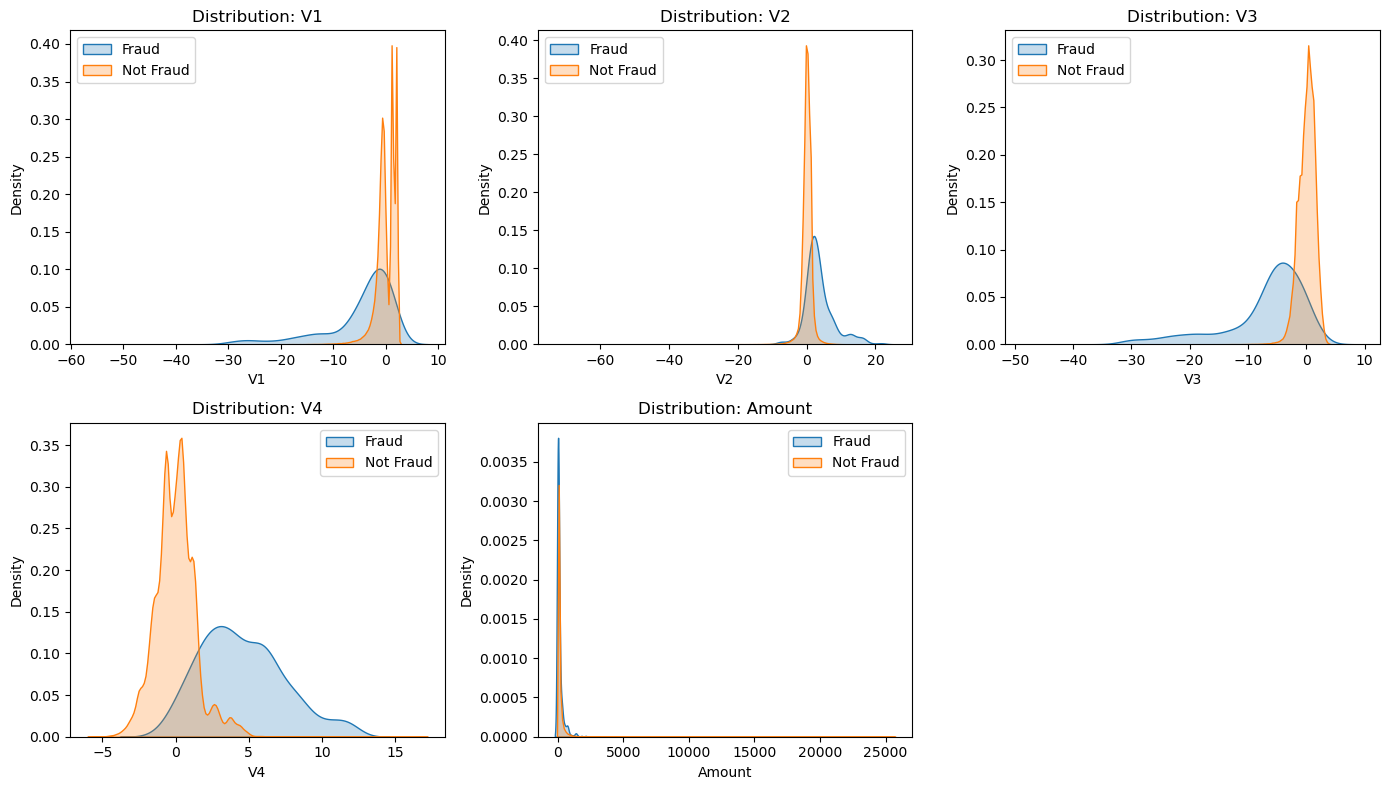

In [23]:
# Running this cell gives the distribution of features (Fraud vs Non-Fraud)
fraud_df = df[df['Class'] == 1]
nonfraud_df = df[df['Class'] == 0]

# Plot a few PCA components and Amount
cols_to_plot = ['V1', 'V2', 'V3', 'V4', 'Amount']
plt.figure(figsize=(14, 8))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(fraud_df[col], label='Fraud', fill=True)
    sns.kdeplot(nonfraud_df[col], label='Not Fraud', fill=True)
    plt.title(f'Distribution: {col}')
    plt.legend()
plt.tight_layout()
plt.show()

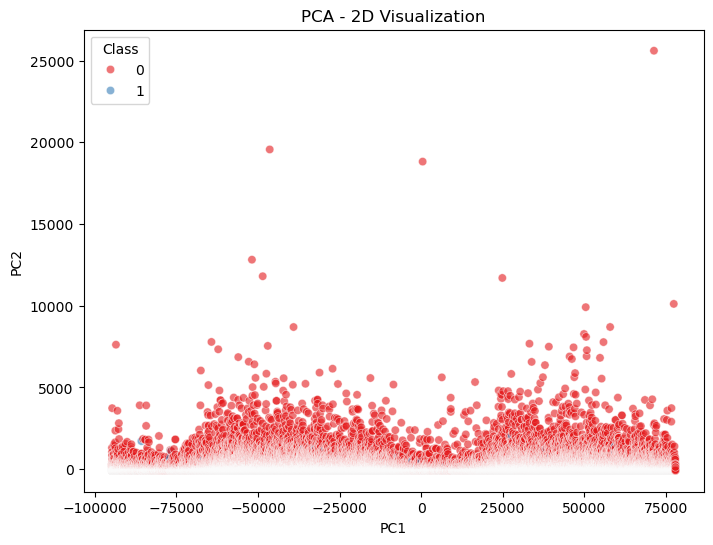

In [24]:
# PCA - Visualization

from sklearn.decomposition import PCA

# Reduce to 2D for plotting
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X[['V'+str(i) for i in range(1, 29)] + ['Amount', 'Time']])

# Convert to dataframe
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Class'] = y.values

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Class', palette='Set1', alpha=0.6)
plt.title('PCA - 2D Visualization')
plt.show()

## DIMENSIONALITY REDUCTION

In [25]:
# Reduce it to 20 components for best retainment results
pca = PCA(n_components=20, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca_bal, y_train_pca_bal = smote.fit_resample(X_train_pca, y_train)

## MODEL BUILDING

In [26]:
# COMMON EVALUATION FUNCTION

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("\n")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

-----LOGISTIC REGRESSION RESULTS-----

Accuracy: 0.9723675432744637
Precision: 0.05434782608695652
Recall: 0.9183673469387755
F1 Score: 0.10262257696693272
ROC AUC: 0.9680805724794139




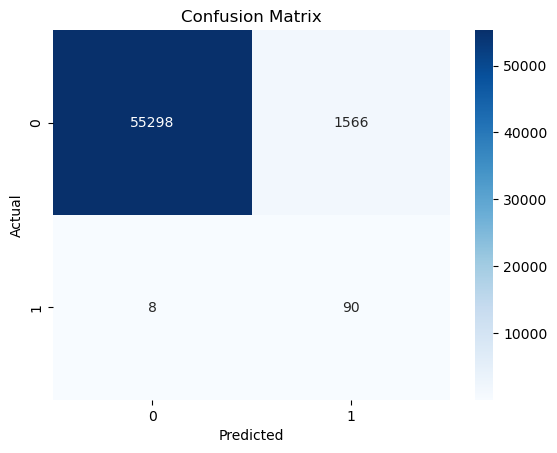

In [27]:
# LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_pca_bal, y_train_pca_bal)

print("-----LOGISTIC REGRESSION RESULTS-----")
evaluate_model(logreg, X_test_pca, y_test)

-----RANDOM FOREST RESULTS-----

Accuracy: 0.999403110845827
Precision: 0.826530612244898
Recall: 0.826530612244898
F1 Score: 0.826530612244898
ROC AUC: 0.9525234034947688




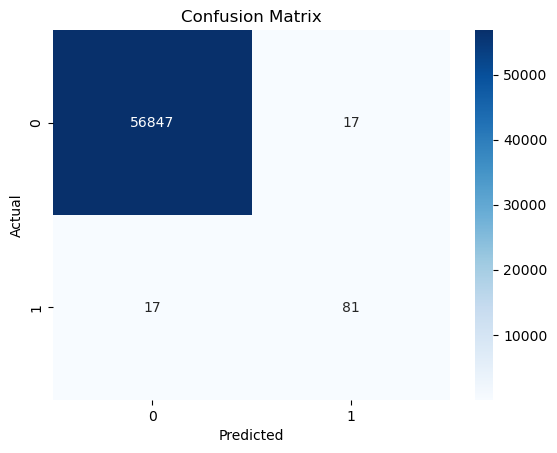

In [28]:
# RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train_pca_bal, y_train_pca_bal)

print("-----RANDOM FOREST RESULTS-----")
evaluate_model(rf, X_test_pca, y_test)

c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


-----XGBOOST RESULTS-----

Accuracy: 0.9988237772550121
Precision: 0.6131386861313869
Recall: 0.8571428571428571
F1 Score: 0.7148936170212766
ROC AUC: 0.9688765102270509




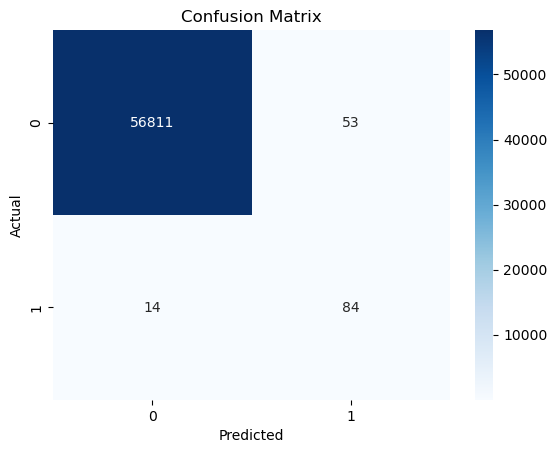

In [29]:
# XGBOOST

import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_pca_bal, y_train_pca_bal)

print("-----XGBOOST RESULTS-----")
evaluate_model(xgb_model, X_test_pca, y_test)

c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


-----VOTING CLASSIFIER RESULTS-----

Accuracy: 0.9990871107053826
Precision: 0.6796875
Recall: 0.8877551020408163
F1 Score: 0.7699115044247787
ROC AUC: 0.9683435522492623




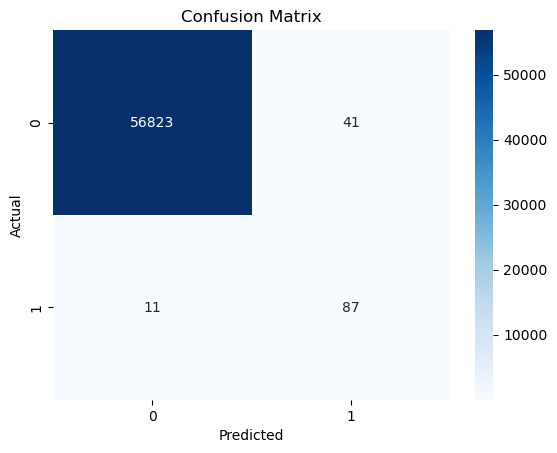

In [30]:
# VOTING CLASSIFIER

from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', logreg),
        ('rf', rf),
        ('xgb', xgb_model)
    ],
    voting='soft'
)

voting_clf.fit(X_train_pca_bal, y_train_pca_bal)

print("-----VOTING CLASSIFIER RESULTS-----")
evaluate_model(voting_clf, X_test_pca, y_test)

-----STACKING CLASSIFIER RESULTS

Accuracy: 0.9993504441557529
Precision: 0.7904761904761904
Recall: 0.8469387755102041
F1 Score: 0.8177339901477833
ROC AUC: 0.9447970381174416




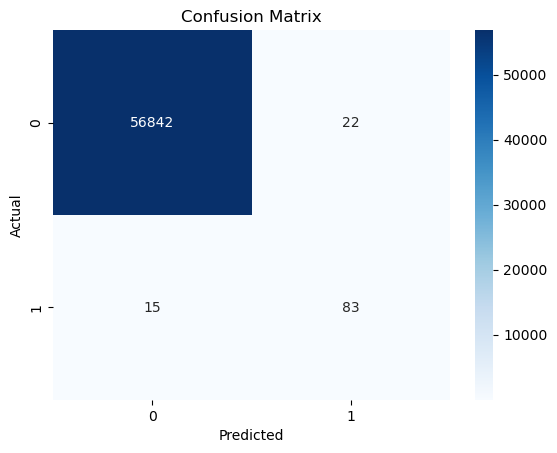

In [31]:
# STACKING CLASSIFIER

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', logreg),
        ('rf', rf),
        ('xgb', xgb_model)
    ],
    final_estimator=LogisticRegression(),
    passthrough=True,
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train_pca_bal, y_train_pca_bal)

print("-----STACKING CLASSIFIER RESULTS")
evaluate_model(stacking_clf, X_test_pca, y_test)


## PLOTTING ROC CURVES

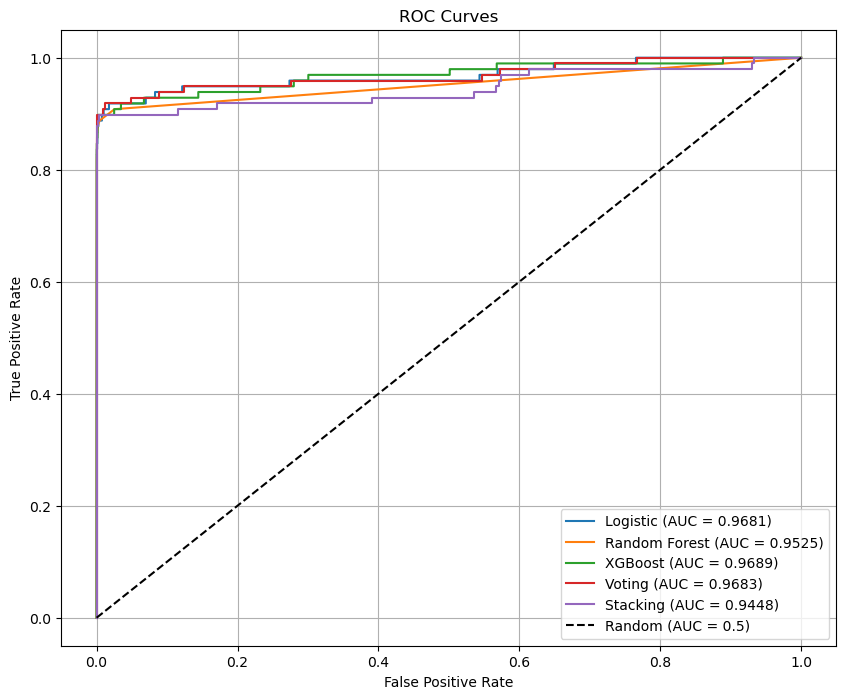

In [32]:
# PLOTTING THE ROC CURVES

from sklearn.metrics import roc_curve, auc

def plot_roc_curves(models, X_test, y_test, title='ROC Curves'):
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Models stored in a dictionary
models_dict = {
    'Logistic': logreg,
    'Random Forest': rf,
    'XGBoost': xgb_model,
    'Voting': voting_clf,
    'Stacking': stacking_clf
}

plot_roc_curves(models_dict, X_test_pca, y_test)

## CHECKING OVERFITTING

In [33]:
# CHECK OVERFITTING - just to make sure

def check_overfitting(model, X_train, y_train, X_test, y_test):
    if hasattr(model, "predict_proba"):
        train_probs = model.predict_proba(X_train)[:, 1]
        test_probs = model.predict_proba(X_test)[:, 1]
    else:
        train_probs = model.decision_function(X_train)
        test_probs = model.decision_function(X_test)

    train_auc = roc_auc_score(y_train, train_probs)
    test_auc = roc_auc_score(y_test, test_probs)
    print(f"Train AUC: {train_auc:.4f} | Test AUC: {test_auc:.4f} | Δ = {train_auc - test_auc:.4f}")

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    print(f"Train F1 : {train_f1:.4f} | Test F1 : {test_f1:.4f} | Δ = {train_f1 - test_f1:.4f}")
    print("-" * 50)

# Apply to all
print("-----OVERFITTING CHECK-----")
for name, model in models_dict.items():
    print(f"{name}:")
    check_overfitting(model, X_train_pca_bal, y_train_pca_bal, X_test_pca, y_test)

-----OVERFITTING CHECK-----
Logistic:
Train AUC: 0.9895 | Test AUC: 0.9681 | Δ = 0.0214
Train F1 : 0.9450 | Test F1 : 0.1026 | Δ = 0.8424
--------------------------------------------------
Random Forest:
Train AUC: 1.0000 | Test AUC: 0.9525 | Δ = 0.0475
Train F1 : 1.0000 | Test F1 : 0.8265 | Δ = 0.1735
--------------------------------------------------
XGBoost:
Train AUC: 1.0000 | Test AUC: 0.9689 | Δ = 0.0311
Train F1 : 1.0000 | Test F1 : 0.7149 | Δ = 0.2851
--------------------------------------------------
Voting:
Train AUC: 1.0000 | Test AUC: 0.9683 | Δ = 0.0317
Train F1 : 0.9999 | Test F1 : 0.7699 | Δ = 0.2300
--------------------------------------------------
Stacking:
Train AUC: 1.0000 | Test AUC: 0.9448 | Δ = 0.0552
Train F1 : 1.0000 | Test F1 : 0.8177 | Δ = 0.1823
--------------------------------------------------


## SAVING THE MODELS

In [37]:
import joblib
import os

# Create models directory if not exists
os.makedirs("models", exist_ok=True)

# Save the best model - in this case, our voting classifier
joblib.dump(voting_clf, "models/voting_model.pkl")

# Save the PCA transformer and scaler
joblib.dump(pca, "models/pca.pkl")
joblib.dump(scaler, "models/scaler.pkl")

print("Successfully Saved: voting_model.pkl, pca.pkl, scaler.pkl in /models/")

Successfully Saved: voting_model.pkl, pca.pkl, scaler.pkl in /models/
